Vector and raster layers are fundamental data formats in Geographic Information Systems (GIS). Vector data represents geographic features as points, lines, and polygons. Vector data is used for precise representation of features like roads or county boundaries. Raster data represents the Earth's surface as a grid of cells, where each cell stores a single value or attribute. Raster data is often used for continuous phenomena such as elevation or land cover.

In this tutorial we will vegetation patterns across multiple watersheds of the Konza Prairie Biological Station near Manhattan, KS.


In [1]:
# Import modules
import numpy as np
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors


## Read vector layer

In [2]:
# Read file with watersheds
vector_path = '../datasets/spatial/konza_watersheds.geojson'
gdf = gpd.read_file(vector_path)
gdf.head(3)


,CODE_1,NAME_1,AREA,PERIMETER,ACRES,HECTARES_1,DATAID_1,DATACODE_2,geometry
0,0R1A,R1A,484815.196184,2939.146533,119.800444,48.481520,GIS0321,GIS032,"POLYGON ((707045.277 4327611.469, 707038.577 4..."
1,R20A,R20A,263364.016292,2509.563160,65.078666,26.336402,GIS0322,GIS032,"POLYGON ((707080.980 4327453.175, 707080.987 4..."
2,002A,2A,283017.160279,2417.724921,69.935063,28.301716,GIS0323,GIS032,"POLYGON ((707362.870 4327681.792, 707364.460 4..."


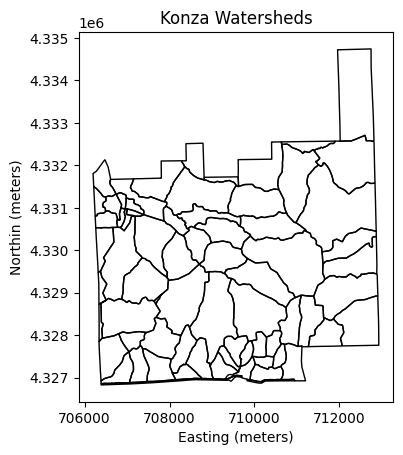

In [3]:
# Visualize vector map of watersheds
gdf.plot(facecolor='None', edgecolor='k')
plt.title('Konza Watersheds')
plt.xlabel('Easting (meters)')
plt.ylabel('Northin (meters)')
plt.show()

In [4]:
# Display coordiante reference system of vector layer
print(gdf.crs)


EPSG:26914


The first step to perform spatial operations between vector and raster layers is to have both data sources in the same coordinate reference system. Our vector layer has geometries in projected coordinates (meters), but the raster datasets will be in geographic coordinates.

To perform operations that involve distance computations is best to have both datasets in projected coordiantes. To perform other operations like clipping layers, then both geographic and projected coordinates should perform similarly. In this example we will convert the vector layer to geographic coordinates.

In [5]:
# Change coordinate reference system from projected to geographic
gdf.to_crs(epsg=4326, inplace=True)
gdf.head(3)

,CODE_1,NAME_1,AREA,PERIMETER,ACRES,HECTARES_1,DATAID_1,DATACODE_2,geometry
0,0R1A,R1A,484815.196184,2939.146533,119.800444,48.481520,GIS0321,GIS032,"POLYGON ((-96.60663 39.07307, -96.60671 39.073..."
1,R20A,R20A,263364.016292,2509.563160,65.078666,26.336402,GIS0322,GIS032,"POLYGON ((-96.60627 39.07163, -96.60627 39.071..."
2,002A,2A,283017.160279,2417.724921,69.935063,28.301716,GIS0323,GIS032,"POLYGON ((-96.60294 39.07362, -96.60292 39.073..."


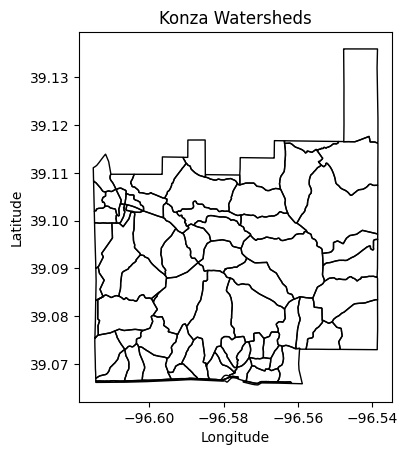

In [6]:
# Visualize vector map of watersheds
gdf.plot(facecolor='None', edgecolor='k')
plt.title('Konza Watersheds')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Read raster layer

The raster layer is a multi-band geo-referenced image at 10-meter spatial resolution obtained from Sentinel-2 satellite. Image data type is unsigned 16-bit ($2^{16}$). The bands are as follows:

- Band 1: Senteninel B03 (green, 560 nm)
- Band 2: Sentinel B04 (red, 665 nm)
- Band 3: Sentinel B08 (near infrared, 842 nm)

The image was downloaded using Sentinel Hub: https://www.sentinel-hub.com/explore/eobrowser/


In [7]:
# Load raster layer
raster_path = '../datasets/spatial/2024-04-03_Sentinel-2_L2A_B03_B04_B08-16bit.tiff'
raster = xr.open_dataarray(raster_path)
raster


<xarray.DataArray 'band_data' (band: 3, y: 1060, x: 1461)>
[4645980 values with dtype=float32]
Coordinates:
  * band         (band) int64 1 2 3
  * x            (x) float64 -96.66 -96.66 -96.66 ... -96.53 -96.53 -96.53
  * y            (y) float64 39.15 39.15 39.15 39.15 ... 39.06 39.06 39.06 39.06
    spatial_ref  int64 ...
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1

In [8]:
# Display CRS for raster layer
print(raster.rio.crs)


EPSG:4326


In [9]:
# Create separate variables to easily keep track of each band
red = raster[1] # Red band
nir = raster[2] # NIR band


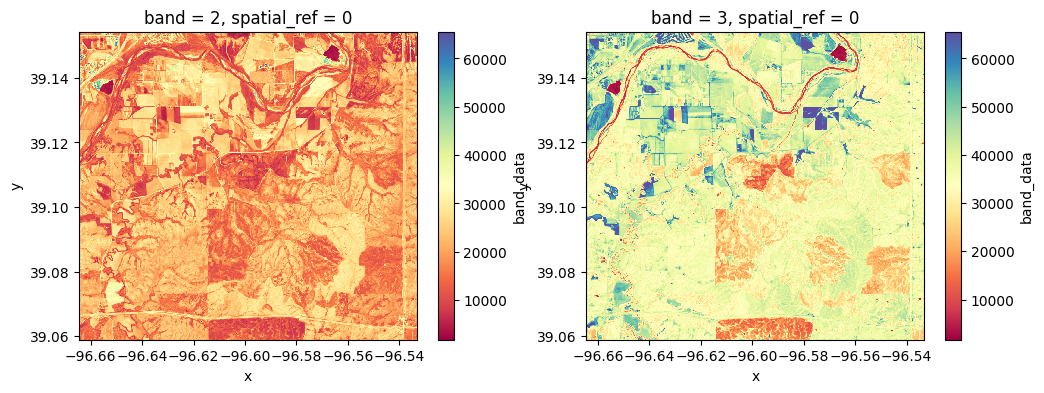

In [10]:
# Visualize raster files (1 band each)
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Red band')
red.plot(cmap='Spectral')

plt.subplot(1,2,2)
plt.title('NIR band')
nir.plot(cmap='Spectral')

plt.show()


## Compute NDVI

Normalized Difference Vegetation Index (NDVI) is a measure typically used in remote sensing to quantify and assess vegetation health and density. It is calculated using near-infrared (NIR) and red light reflectance values over an area as follows:

$$ NDVI = \frac{NIR-Red}{NIR+Red}$$

NDVI values range from -1 to 1, where higher values indicate healthier and denser vegetation, typically falling between 0.2 and 0.8 for vegetation. Bare soil and rocks fall have values ranging from 0 to 0.2. Bodies of water like ponds, likes, rivers, and oceans typically have negative values close to -1.

In [12]:
# Calculate NDVI
ndvi = (nir - red)/(nir + red)
ndvi

<xarray.DataArray 'band_data' (y: 1060, x: 1461)>
array([[0.20274895, 0.20937616, 0.20950142, ..., 0.67129827, 0.66197807,
        0.6533825 ],
       [0.20902824, 0.21146326, 0.20774542, ..., 0.6241462 , 0.6243218 ,
        0.61213624],
       [0.2056777 , 0.20352827, 0.20263384, ..., 0.4648589 , 0.46888125,
        0.43359682],
       ...,
       [0.24272305, 0.24409018, 0.29347083, ..., 0.24446614, 0.245708  ,
        0.23017304],
       [0.23893936, 0.25726736, 0.30064335, ..., 0.23905072, 0.21922347,
        0.21036135],
       [0.25735095, 0.27477464, 0.32591128, ..., 0.21947752, 0.22523181,
        0.21821591]], dtype=float32)
Coordinates:
  * x            (x) float64 -96.66 -96.66 -96.66 ... -96.53 -96.53 -96.53
  * y            (y) float64 39.15 39.15 39.15 39.15 ... 39.06 39.06 39.06 39.06
    spatial_ref  int64 0

Now that we have the NDVI raster layer, here a few additional commands that could be useful:

```python
# Get NDVI values as Numpy array
ndvi.values

# Get latitude values as Numpy array
ndvi.coords['y'].values

# Get a 3 by 3 slice
ndvi[0:3,0:3]

# Find NDVI value for nearest point
ndvi.sel(x=-96.664356, y=39.15406606, method='nearest')
```

## Define custom colormap

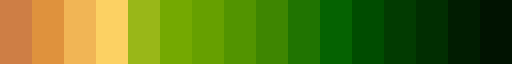

In [13]:
# Palette of colors NDVI
hex_palette = ['#CE7E45', '#DF923D', '#F1B555', '#FCD163', '#99B718', '#74A901',
             '#66A000', '#529400', '#3E8601', '#207401', '#056201', '#004C00', '#023B01',
             '#012E01', '#011D01', '#011301']

# Use the built-in ListedColormap function to do the conversion
ndvi_cmap = colors.ListedColormap(hex_palette)
ndvi_cmap.set_bad('#FEFEFE')
ndvi_cmap.set_under('#0000FF')
ndvi_cmap

In [14]:
# Add new colormap to list of Matplotlib's colormaps
plt.colormaps.register(cmap=ndvi_cmap, name='ndvi')


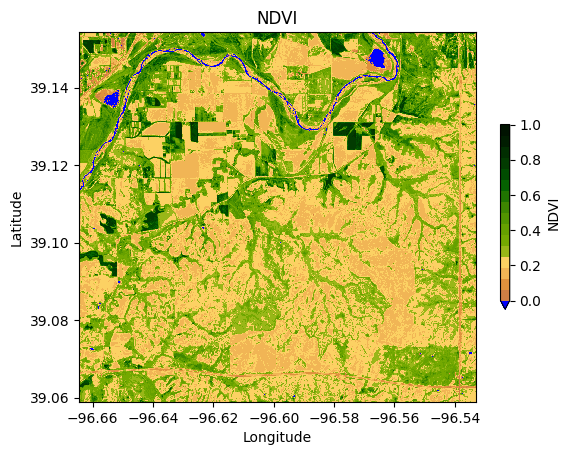

In [15]:
# Visualize NDVI for the entire area of the image
ndvi.plot(cmap='ndvi', vmin=0.0, vmax=1.0, 
          cbar_kwargs={'label':'NDVI', 'shrink':0.5})
plt.title('NDVI')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Clip NDVI raster to watersheds

In [16]:
# Define a function to clip the raster with each polygon and return a numpy array
clip_fn = lambda polygon, R: R.rio.clip([polygon.geometry], 
                                        crs=R.rio.crs, 
                                        all_touched=True)

# Apply the function to each row in the GeoDataFrame to create a new 'clipped_raster' column
gdf['clipped_raster'] = gdf.apply(lambda row: clip_fn(row, ndvi), axis=1)

# Inspect resulting GeoDataframe
gdf.head(3)


,CODE_1,NAME_1,AREA,PERIMETER,ACRES,HECTARES_1,DATAID_1,DATACODE_2,geometry,clipped_raster
0,0R1A,R1A,484815.196184,2939.146533,119.800444,48.481520,GIS0321,GIS032,"POLYGON ((-96.60663 39.07307, -96.60671 39.073...",[[<xarray.DataArray 'band_data' ()>\narray(nan...
1,R20A,R20A,263364.016292,2509.563160,65.078666,26.336402,GIS0322,GIS032,"POLYGON ((-96.60627 39.07163, -96.60627 39.071...",[[<xarray.DataArray 'band_data' ()>\narray(nan...
2,002A,2A,283017.160279,2417.724921,69.935063,28.301716,GIS0323,GIS032,"POLYGON ((-96.60294 39.07362, -96.60292 39.073...",[[<xarray.DataArray 'band_data' ()>\narray(nan...


## Visualize a specific clipped watershed

We will choose the K1B watershed to show the NDVI for the entire area.


In [69]:
# Select watershed
idx = gdf['NAME_1'] == 'K1B'
row = gdf[idx].index[0]
print(row)


31


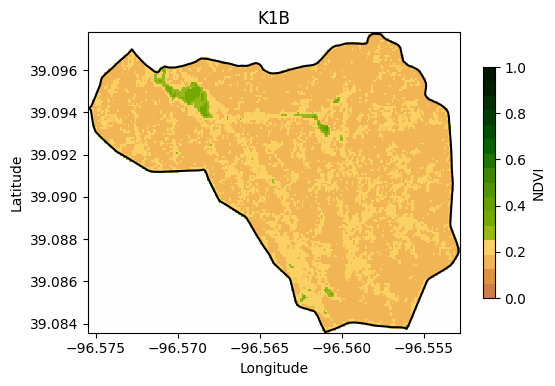

In [70]:
# Create figure of selected watershed
fig, ax = plt.subplots(figsize=(6, 6))
gdf.loc[ [row], 'geometry'].boundary.plot(ax=ax, edgecolor='k')
gdf.loc[row, 'clipped_raster'].plot(ax=ax, cmap='ndvi', 
                                    add_colorbar=True, vmin=0.0, vmax=1.0,
                                   cbar_kwargs={'label':'NDVI', 'shrink':0.5})
ax.set_title('K1B')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()


Notice that to plot the boundary of the watershed we had to do: `gdf.loc[[row],'geometry']` instead of `gdf.loc[row,'geometry']`. This is because we need to access the GeoSeries rather than the Shapely polygon.

## Compute mean NDVI for each watershed

In [71]:
# Create empty list to append watershed NDVI values
ndvi_avg = []

# Iterate over each watershed
for k,row in gdf.iterrows():
    ndvi_avg.append(np.nanmean(row['clipped_raster'].data))

# Add list of NDVI values to GeoDataframe
gdf.insert(gdf.shape[1]-1, 'ndvi_avg', ndvi_avg)

# Inspect results
gdf.head(3)


,CODE_1,NAME_1,AREA,PERIMETER,ACRES,HECTARES_1,DATAID_1,DATACODE_2,geometry,ndvi_avg,clipped_raster
0,0R1A,R1A,484815.196184,2939.146533,119.800444,48.481520,GIS0321,GIS032,"POLYGON ((-96.60663 39.07307, -96.60671 39.073...",0.187059,[[<xarray.DataArray 'band_data' ()>\narray(nan...
1,R20A,R20A,263364.016292,2509.563160,65.078666,26.336402,GIS0322,GIS032,"POLYGON ((-96.60627 39.07163, -96.60627 39.071...",0.196402,[[<xarray.DataArray 'band_data' ()>\narray(nan...
2,002A,2A,283017.160279,2417.724921,69.935063,28.301716,GIS0323,GIS032,"POLYGON ((-96.60294 39.07362, -96.60292 39.073...",0.173563,[[<xarray.DataArray 'band_data' ()>\narray(nan...


## Create static map

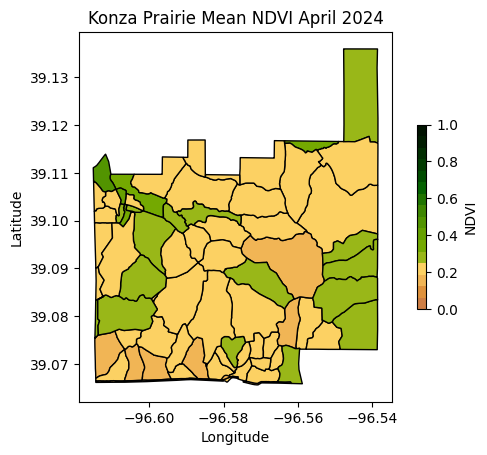

In [72]:
# Create figure with mean NDVI values for each watershed
gdf.plot(column='ndvi_avg', edgecolor='k', cmap='ndvi', 
         legend=True, vmin=0.0, vmax=1.0, legend_kwds={'label':'NDVI', 'shrink':0.5})
plt.title('Konza Prairie Mean NDVI April 2024')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
#plt.savefig('Konza Mean NDVI April 2024.jpg', dpi=300)
plt.show()


## Create interactive map

In [74]:
# Create interactive map
gdf.iloc[:,:-1].explore(column='ndvi_avg', k=10, cmap='ndvi',
                        style_kwds={'stroke':True,'color':'black','width':1},
                        legend_kwds={'caption':'NDVI'})
